# Infering using the Dirichlet Process Method
## <font color='red'> Assumption: The data gives an indication of the underlying distributions <b> and </b> number of clusters. </font>
### <font color='red'> After convergence, the mean and covariance matrices are drawn from a distribution for each cluster. </font>

## Import modules

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Load data

In [2]:
npzfile = np.load('GaussianMixture.npz')
n_dim = len(npzfile.files) - 1
print(n_dim)
print(npzfile.files)

2
['x_sample', 'y_sample', 'mixing_idx']


## Plot data
The information which component generated which sample is deliberately not plotted.

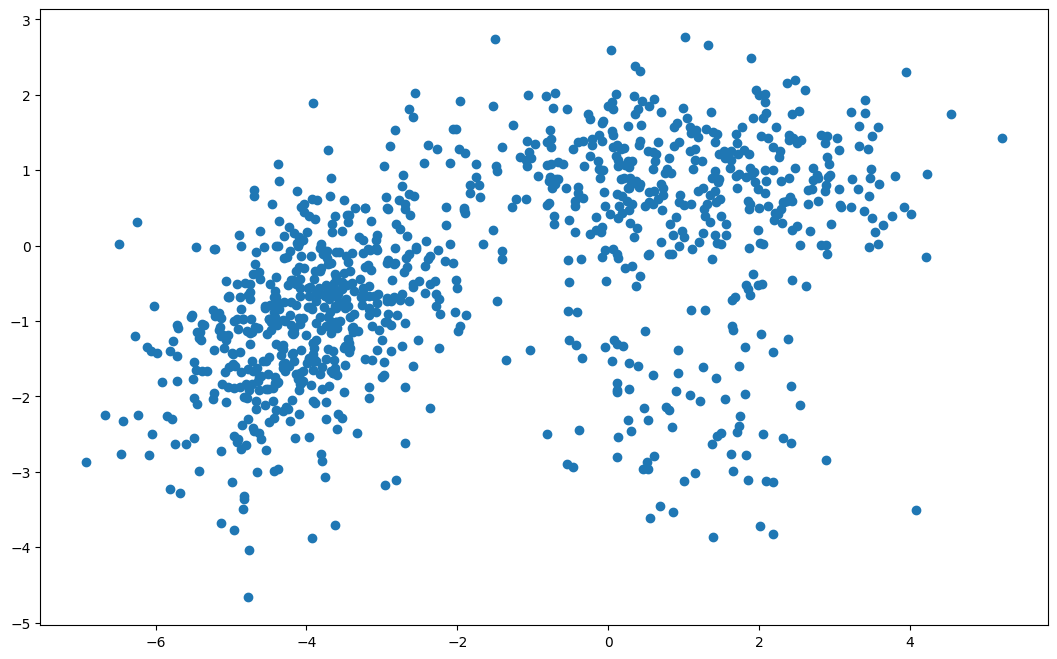

In [3]:
x_sample = npzfile['x_sample']
y_sample = npzfile['y_sample']
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample)
plt.show()

## Dirichlet Process Method
For illustration, *sklearn.mixture.BayesianGaussianMixture* is not used, but a new function is implemented. For explanation and formulae please see the slides.

In [4]:
def InferDP(data,alpha0,mean0,lambda0,scale0,df0,n_iter = 100):
    """ Input:
    data:     data,
    alpha0:   prior concentration parameter,
    mean0:    prior location vector,
    lambda0:  prior mean fraction,
    scale:    prior scale matrix,
    df:       prior degrees of freedom,
    n_iter:   number of iterations
    Output:
    idx:      index vector which process generated the sample,
    p:        array of mixing coefficients,
    means:    array of the means of all components,
    covs:     array of the covariance matrices of all components."""
    size = len(data)
    n_dim = data.shape[1]
    # Indicate no cluster assignment with -1.
    idx = -np.ones(size,np.int8)

    # Consider the data in a random order and initialize cluster assignments.
    r = list(range(size))
    np.random.shuffle(r)
    # Assign first data sample to first component.
    idx[r[0]] = 0
    comp_size =  np.array([1])
    n_comp = 1
    # Update hyperparameters for first component.
    comp_lambda =  np.array([lambda0+1])
    v = data[r[0],:]
    temp = (v-mean0).reshape(1,n_dim)
    comp_scale = np.reshape(scale0 + lambda0/comp_lambda.item(0) * temp.T @ temp,(n_dim,n_dim,1))
    comp_mean = np.reshape((lambda0*mean0+v)/comp_lambda.item(0),(n_dim,1))
    comp_df = np.array([df0+1])
    # Draw mean and covariance for first cluster.
    covs = np.reshape(ss.invwishart.rvs(df = comp_df.item(0), scale = comp_scale[:,:,0]),(n_dim,n_dim,1))
    means = np.reshape(np.random.multivariate_normal(mean = comp_mean[:,0], cov = covs[:,:,0]/comp_lambda.item(0)),(n_dim,1))
    for n,l in enumerate(np.delete(r,0)):
        v = data[l,:]
        # Calculate cluster assignment probabilities and the probability of belonging to an unseen component.
        p = np.zeros(n_comp+1)
        for k in range(n_comp):
            p[k] = comp_size.item(k)/(n+1+alpha0) * \
                  ss.multivariate_normal.pdf(v,means[:,k],covs[:,:,k])
        p[n_comp] = alpha0/(n+1+alpha0) * ss.multivariate_normal.pdf(v,mean0,scale0)
        p = p/sum(p)
        # Sample new indicator variable.
        comp_idx =  np.random.choice(len(p),p=p)
        idx[l] = comp_idx
        if comp_idx < n_comp:
            #  Update the component the sample is assigned to.
            postlambda = comp_lambda.item(comp_idx)+1
            temp = (v-comp_mean[:,comp_idx]).reshape(1,n_dim)
            comp_scale[:,:,comp_idx] = comp_scale[:,:,comp_idx] + \
              comp_lambda.item(comp_idx)/postlambda * temp.T @ temp
            comp_mean[:,comp_idx] = (comp_lambda.item(comp_idx)*comp_mean[:,comp_idx]+v)/postlambda
            comp_df[comp_idx] = comp_df.item(comp_idx) +1
            comp_lambda[comp_idx] = postlambda
            # Draw new mean and covariance.
            covs[:,:,comp_idx] = ss.invwishart.rvs(df = comp_df.item(comp_idx), scale = comp_scale[:,:,comp_idx])
            means[:,comp_idx] = np.random.multivariate_normal(mean = comp_mean[:,comp_idx],
                                                            cov = covs[:,:,comp_idx]/comp_lambda.item(comp_idx))
            comp_size[comp_idx] = comp_size.item(comp_idx) +1
        else:
            #  Create new component for this sample.
            comp_lambda = np.concatenate((comp_lambda,np.array([lambda0 + 1])))
            temp = (v-mean0).reshape(1,n_dim)
            scale = scale0 + lambda0/(lambda0+1) * temp.T @ temp
            mean = (lambda0*mean0 + v)/(lambda0+1)
            comp_scale = np.concatenate((comp_scale,np.reshape(scale,(n_dim,n_dim,1))),2)
            comp_mean = np.concatenate((comp_mean,np.reshape(mean,(n_dim,1))),1)
            comp_df = np.concatenate((comp_df,np.array([df0 + 1])))
            n_comp = n_comp +1
            # Draw mean and covariance of new component.
            cov = ss.invwishart.rvs(df = df0+1, scale = scale)
            mean = np.random.multivariate_normal(mean = mean, cov = cov/(lambda0+1))
            covs = np.concatenate((covs,np.reshape(cov,(n_dim,n_dim,1))),2)
            means = np.concatenate((means,np.reshape(mean,(n_dim,1))),1)
            comp_size = np.concatenate((comp_size,np.array([1])))

    for i in range(n_iter):
        # Consider the data in a random order.
        r = list(range(size))
        np.random.shuffle(r)
        for n in r:
            v = data[n,:]
            l = idx[n]
            # Remove this sample from the cluster it was assigned to.
            comp_size[l] = comp_size.item(l) -1
            if comp_size[l] == 0:
                # Remove empty component.
                comp_size = np.delete(comp_size,l)
                comp_scale = np.delete(comp_scale,l,2)
                comp_mean = np.delete(comp_mean,l,1)
                comp_df = np.delete(comp_df,l)
                comp_lambda = np.delete(comp_lambda,l)
                covs = np.delete(covs,l,2)
                means = np.delete(means,l,1)
                # Adjust component numbering.
                temp = idx > l
                idx[temp] = idx[temp] - 1
                n_comp = n_comp -1
            else:
                priorlambda = comp_lambda.item(l)-1
                temp = (v-comp_mean[:,l]).reshape(1,n_dim)
                comp_scale[:,:,l] = comp_scale[:,:,l] - comp_lambda.item(l)/priorlambda * temp.T @ temp
                comp_mean[:,l] = (comp_lambda.item(l)*comp_mean[:,l]-v)/priorlambda
                comp_df[l] = comp_df.item(l) -1
                comp_lambda[l] = priorlambda
                # Draw new mean and covariance.
                covs[:,:,l] = ss.invwishart.rvs(df = comp_df.item(l), scale = comp_scale[:,:,l])
                means[:,l]=np.random.multivariate_normal(mean = comp_mean[:,l], cov = covs[:,:,l]/comp_lambda.item(l))

            # Calculate cluster assignment probabilities.
            p = np.zeros(n_comp+1)
            for k in range(n_comp):
                p[k] = comp_size.item(k)/(size-1+alpha0) * ss.multivariate_normal.pdf(v,means[:,k],covs[:,:,k])
            p[n_comp] = alpha0/(size-1+alpha0) * ss.multivariate_normal.pdf(v,mean0,scale0)
            p = p/sum(p)
            # Sample new indicator variable.
            l = np.random.choice(len(p),p=p)
            idx[n] = l

            if l<n_comp:
                #  Update the component the sample is assigned to.
                postlambda = comp_lambda.item(l)+1
                temp = (v-comp_mean[:,l]).reshape(1,n_dim)
                comp_scale[:,:,l] = comp_scale[:,:,l] + comp_lambda.item(l)/postlambda * temp.T @ temp
                comp_mean[:,l] = (comp_lambda.item(l)*comp_mean[:,l]+v)/postlambda
                comp_df[l] = comp_df.item(l) +1
                comp_lambda[l] = postlambda
                # Draw new mean and covariance.
                covs[:,:,l] = ss.invwishart.rvs(df = comp_df.item(l), scale = comp_scale[:,:,l])
                means[:,l]=np.random.multivariate_normal(mean = comp_mean[:,l], cov = covs[:,:,l]/comp_lambda.item(l))
                comp_size[l] = comp_size.item(l) +1
            else:
                #  Create new component for this sample.
                comp_lambda = np.concatenate((comp_lambda,np.array([lambda0 + 1])))
                temp = (v-mean0).reshape(1,n_dim)
                scale = scale0 + lambda0/(lambda0+1) * temp.T @ temp
                mean = (lambda0*mean0 + v)/(lambda0+1)
                comp_scale = np.concatenate((comp_scale,np.reshape(scale,(n_dim,n_dim,1))),2)
                comp_mean = np.concatenate((comp_mean,np.reshape(mean,(n_dim,1))),1)
                comp_df = np.concatenate((comp_df,np.array([df0 + 1])))
                n_comp = n_comp +1
                # Draw mean and covariance of new component.
                cov = ss.invwishart.rvs(df = df0+1, scale = scale)
                mean = np.random.multivariate_normal(mean = mean, cov = cov/(lambda0+1))
                covs = np.concatenate((covs,np.reshape(cov,(n_dim,n_dim,1))),2)
                means = np.concatenate((means,np.reshape(mean,(n_dim,1))),1)
                comp_size = np.concatenate((comp_size,np.array([1])))
    # Calculate final cluster assignment probabilities.
    p = np.zeros((size,n_comp+1))
    for k in range(n_comp):
        p[:,k] = comp_size.item(k)/(size-1+alpha0) * ss.multivariate_normal.pdf(data,means[:,k],covs[:,:,k])
    p[:,n_comp] = alpha0/(size-1+alpha0) * ss.multivariate_normal.pdf(data,mean0,scale0)
    p = p/p.sum(axis=1,keepdims=True)
    weights = comp_size/size
    return idx, p, weights, means, covs

### Initialize priors
The priors are chosen to be uninformative. The *location vector* $\mathbf{m}$ is initialized to the mean of the all data samples. The *mean fraction* $\lambda$ is intialized to $1$ supporting the assumption that the clusters overlay. The *inverse scale matrix* $\boldsymbol{\Psi}$ is initialized to the average squared distance from mean in each dimension times the identity. The degrees of freedom $\nu$ is set to the number of dimensions. This is most uninformative.

In [5]:
data = np.stack((x_sample, y_sample)).T
mean0 = np.mean(data,0)
lambda0 = 1
scale0 = np.sum(np.square(data - mean0))/len(data) * np.identity(n_dim)
df0 = n_dim
n_iter = 30

### Training
The hyperparameter $\alpha$ is set to larger than $0.5$ meaning generation of new clusters is slightly favoured.

In [6]:
alpha0 = 0.7
idx, p, weights, means, covs = InferDP(data,alpha0,mean0,lambda0,scale0,df0,n_iter)

#### Results
The data was generated mixing three normal distributions,
\begin{equation}
\mathcal{N}\left( \left( {-3} \atop {-1} \right), \left( 1 \atop 0.5 \right. \left. 0.5 \atop 1 \right) \right), \mathcal{N}\left( \left( 1 \atop 1 \right), \left( 2 \atop 0 \right. \left. 0 \atop 0.5 \right) \right), \mathcal{N}\left( \left( 1 \atop {-2} \right), \left( 1 \atop 0 \right. \left. 0 \atop 1 \right) \right).
\end{equation}
with mixing coefficients 0.5, 0.25 and 0.25.

In [7]:
order = np.flip(np.argsort(weights))
print(order)
colours =  [(1,0,0), (0,1,0), (0,0,1), (1,1,0), (0,1,1), (1,0,1), (0,0,0)]
c = np.zeros((len(idx),3))
print('Mixing coefficients: ', weights[order], '\n')
for i,j in enumerate(order):
    c[idx==j,:] = colours[i]
    print('Component', i+1)
    print('Mean:', means[:,j])
    print('Covariance:', covs[:,:,j], '\n')

[1 3 2 0]
Mixing coefficients:  [0.535 0.356 0.092 0.017] 

Component 1
Mean: [-4.05444284 -1.0555398 ]
Covariance: [[0.99305646 0.45223748]
 [0.45223748 1.03580494]] 

Component 2
Mean: [1.13273183 0.93166218]
Covariance: [[ 2.44682797 -0.02496395]
 [-0.02496395  0.41508435]] 

Component 3
Mean: [ 0.8823869  -1.80668292]
Covariance: [[ 1.30851332 -0.29759432]
 [-0.29759432  1.11412804]] 

Component 4
Mean: [-0.17569234  0.1878355 ]
Covariance: [[1.07474655 1.4143626 ]
 [1.4143626  6.13546443]] 



#### Plot data
First coloured by sampled cluster assignments. Quite a few assignments seem incorrect. More iterations could resolve this, but only if there is no uncertainty in the data itself (see below).

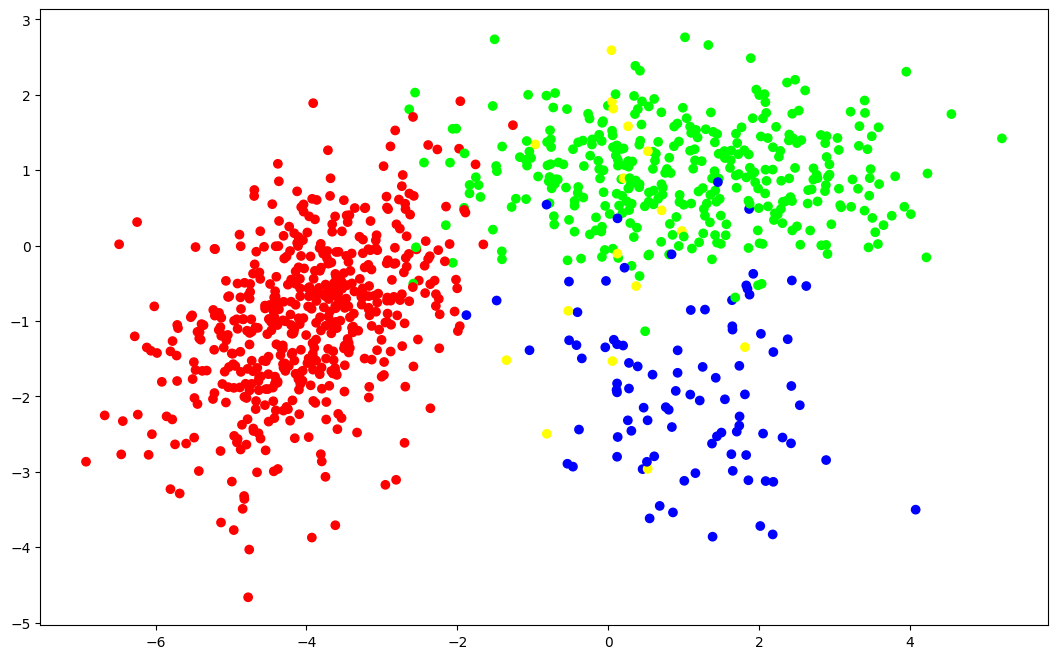

In [8]:
fig = plt.figure(figsize=(13,8))
plt.scatter(x_sample, y_sample, c = c)
plt.show()

Secondly, each sample is given a colour mixed from red, green and blue according to the estimated posterior assignment probabilities, also known as *responsibilities* of the *three largest* clusters. The regions where we have a mix of colours are those where the responsibilities are *not* clearly favouring one cluster. This also explains the incorrect assignments in the previous plot.

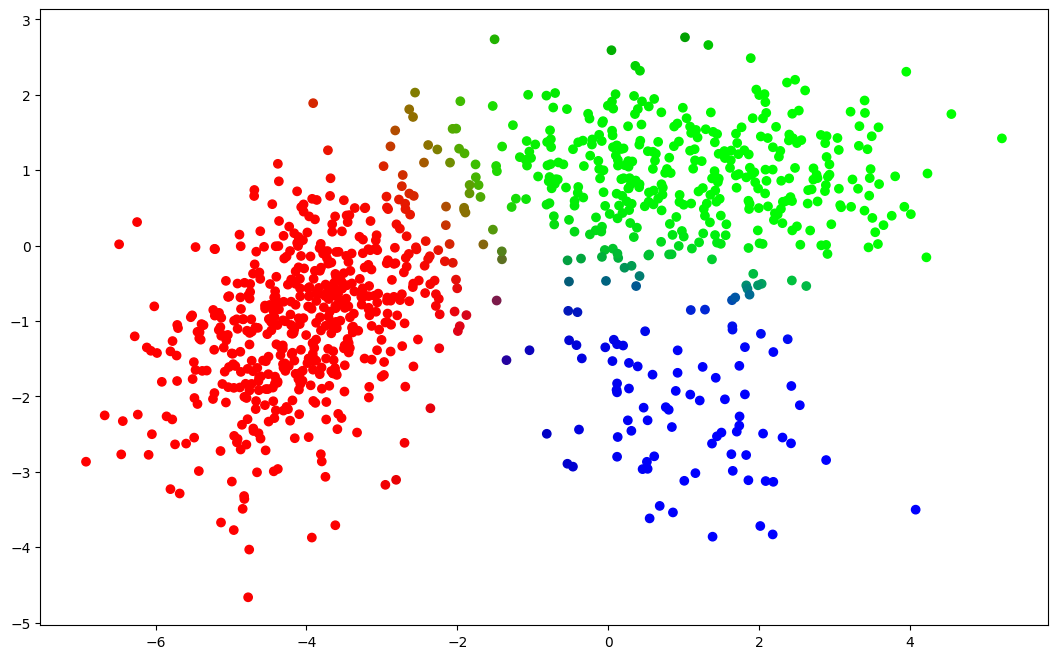

In [9]:
fig = plt.figure(figsize=(13,8))
c = p[:,order[0:3]]
# In case there are less than three clusters, pad with zeros.
while c.shape[1] < 3:
  c = np.stack((c, np.zeros((c.shape[0],1))))
plt.scatter(x_sample, y_sample, c = c)
plt.show()

## Exploration
Run the Dirichlet Process Model several times with the same number of iterations and and fixed hyperparameter $\alpha$. Then change the number of iterations and $\alpha$. Observe how this influences the results. You should also notice that even with a good number of iterations and choice of $\alpha$ the results can be poor, if the algorithms is run again and again and the performance compared.